In [1]:
import sys 
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
columns_to_agg = ['test_loss', 'test_loss_true', 'test_mae', 'test_mse']
sub_columns = ['aware', 'unaware']
Clusters = ['WEBSTER', 'HIGH', 'TED', 'HAMILTON', 'RINCONADA', 'CAMBRIDGE', 'MPL', 'BRYANT']
data_path = "../data/LossCSVs"

In [3]:
import os

def load_csv(model, lead, strategy, censor_level):
    base_name = f"{data_path}/loss_{model}lead{lead}_{strategy}{censor_level}"

    aware_path = f"{base_name}.csv"
    unaware_path = f"{base_name}_UW.csv"

    if not os.path.exists(aware_path):
        print(f"Warning: Missing data for aware {model} {lead} {strategy}{censor_level}. Path {aware_path} does not exist")
        raise FileNotFoundError
    else:
        aware_df = pd.read_csv(aware_path)
        aware_df = aware_df[aware_df.State != 'crashed']
    if not os.path.exists(unaware_path):
        print(f"Warning: Missing data for unaware {model} {lead} {strategy}{censor_level}.Path {unaware_path} does not exist")
        raise FileNotFoundError
    else:
        unaware_df = pd.read_csv(unaware_path)
        unaware_df = unaware_df[unaware_df.State != 'crashed']
    return aware_df, unaware_df

def calculate_losses(df, df_unaware, model_name, columns_to_agg, strategy, forecast_lead):
    agg_mean = np.round(df[columns_to_agg].mean(),2)
    agg_std = np.round(df[columns_to_agg].std(),2)

    agg_mean_unaware = np.round(df_unaware[columns_to_agg].mean(),2)
    agg_std_unaware = np.round(df_unaware[columns_to_agg].std(),2)

    new_data = {
        'Forecast lead': [forecast_lead],
        'Strategy': [strategy+str(censor_level)],
        'Model': model_name.upper(),
    }
    for col in columns_to_agg:
        mean_unaware = agg_mean_unaware[col].astype(str)
        std_unaware = agg_std_unaware[col].astype(str)
        # Unaware models don't have a censored loss
        if col == 'test_loss':
            new_data[(col, 'aware')] = '$' + agg_mean[col].astype(str) + r' \pm ' + agg_std[col].astype(str) + '$'
            new_data[(col, 'unaware')] = '--'
        else:
            new_data[(col, 'aware')] = '$' + agg_mean[col].astype(str) + r' \pm ' + agg_std[col].astype(str) + '$'
            new_data[(col, 'unaware')] = '$' + mean_unaware + r' \pm ' + std_unaware + '$'


    return pd.DataFrame(new_data)

leads = [1, 48]
strategies = {
    'dyn': [1, 2],
    'stat': [3, 2]
}

models = ['tgcn', 'gru', 'lstm', 'ar']
leads = [1, 48]

# Store the dataframes in a dictionary

# Iterate over all the combinations
multi_cols = pd.MultiIndex.from_product([columns_to_agg, sub_columns], 
                                        names=['Metric', 'State'])
df_losses = pd.DataFrame(columns=['Forecast lead', 'Strategy', 'Model'] + list(multi_cols))

no_runs_dict = {}

for lead in leads:
    for strategy, censor_levels in strategies.items():
        for censor_level in censor_levels:
            for model in models:
                # Load data
                aware, unaware = load_csv(model, lead, strategy, censor_level)
                # Figure out how many runs we have
                if model != 'tgcn':
                    no_runs_unaware = np.floor(unaware.shape[0]/8)
                    unaware = unaware.groupby('cluster').head(no_runs_unaware).copy()
                    unaware.loc[:, "run_no"] = np.repeat(np.arange(1, 1+no_runs_unaware), 8)
                else:
                    unaware.loc[:, "run_no"] = np.repeat(np.arange(1, 1+unaware.shape[0]), 1)
                unaware_agg = unaware.groupby('run_no').mean().reset_index()
                if model != 'tgcn':
                    no_runs_aware = np.floor(aware.shape[0]/8)
                    # print(f"Model {model} lead {lead} strategy {strategy} censor level {censor_level} has {no_runs_aware} aware runs")
                    # Take the first no_runs runs
                    aware = aware.groupby('cluster').head(no_runs_aware).copy()
                    aware.loc[:, "run_no"] = np.repeat(np.arange(1, 1+no_runs_aware), 8)
                else:
                    aware.loc[:, "run_no"] = np.repeat(np.arange(1, 1+aware.shape[0]), 1)
                # Mean over runs
                aware_agg = aware.groupby('run_no').mean().reset_index()

                df_losses = pd.concat([df_losses, calculate_losses(aware_agg, unaware_agg, model, columns_to_agg, strategy, lead)], ignore_index=True)

In [4]:
print(df_losses.style.to_latex())

\begin{tabular}{llllllllllll}
 & Forecast lead & Strategy & Model & ('test_loss', 'aware') & ('test_loss', 'unaware') & ('test_loss_true', 'aware') & ('test_loss_true', 'unaware') & ('test_mae', 'aware') & ('test_mae', 'unaware') & ('test_mse', 'aware') & ('test_mse', 'unaware') \\
0 & 1 & dyn1 & TGCN & $0.97 \pm 0.0$ & -- & $-0.09 \pm 0.0$ & $-0.08 \pm 0.01$ & $0.68 \pm 0.02$ & $0.68 \pm 0.01$ & $1.1 \pm 0.05$ & $1.08 \pm 0.03$ \\
1 & 1 & dyn1 & GRU & $0.88 \pm 0.0$ & -- & $-0.16 \pm 0.01$ & $-0.19 \pm 0.0$ & $0.58 \pm 0.01$ & $0.5 \pm 0.01$ & $0.82 \pm 0.04$ & $0.58 \pm 0.02$ \\
2 & 1 & dyn1 & LSTM & $0.93 \pm 0.0$ & -- & $-0.1 \pm 0.01$ & $-0.14 \pm 0.0$ & $0.68 \pm 0.03$ & $0.56 \pm 0.0$ & $1.04 \pm 0.1$ & $0.63 \pm 0.01$ \\
3 & 1 & dyn1 & AR & $1.12 \pm 0.04$ & -- & $0.17 \pm 0.03$ & $-0.03 \pm 0.01$ & $1.21 \pm 0.05$ & $0.75 \pm 0.04$ & $6.49 \pm 1.98$ & $1.51 \pm 0.45$ \\
4 & 1 & dyn2 & TGCN & $0.9 \pm 0.02$ & -- & $-0.06 \pm 0.01$ & $-0.07 \pm 0.0$ & $0.74 \pm 0.03$ & $0.7 \pm 

In [5]:
load_csv('lstm', 48, 'dyn', 1)[1].groupby('cluster')[['test_loss_true']].agg(['mean', 'std'])

test_loss_true          
                    mean       std
cluster                           
BRYANT         -0.615895  0.023245
CAMBRIDGE      -0.503148  0.020897
HAMILTON        0.580586  0.009247
HIGH           -0.224278  0.023968
MPL             0.773931  0.003291
RINCONADA       0.919445  0.031299
TED             0.237799  0.018759
WEBSTER        -0.038665  0.014082

In [6]:
df_losses[(df_losses.Model == 'LSTM') & (df_losses.Strategy == 'stat3') & (df_losses['Forecast lead'] == 48)].groupby(['Forecast lead',  'Strategy', 'Model']).first()

,,,"(test_loss, aware)","(test_loss, unaware)","(test_loss_true, aware)","(test_loss_true, unaware)","(test_mae, aware)","(test_mae, unaware)","(test_mse, aware)","(test_mse, unaware)"
Forecast lead,Strategy,Model,,,,,,,,
48,stat3,LSTM,$0.91 \pm 0.01$,--,$0.17 \pm 0.02$,$0.29 \pm 0.02$,$0.99 \pm 0.02$,$1.08 \pm 0.02$,$1.89 \pm 0.09$,$2.45 \pm 0.06$


## Losses forecast 1

In [7]:
import pandas as pd

import pandas as pd

data_unaware = {
    'test_loss': [1.3201844692230225, 1.3913191556930542, 1.1560873985290527, 1.2205795049667358, 0.8416935801506042, 0.7753558158874512, 1.1552358865737915, 1.1493364572525024],
    'test_loss_true': [-0.7602114081382751, -0.7956538796424866, 0.5274457335472107, -0.41923677921295166, 0.5593833923339844, 0.5897154808044434, -0.011788301169872284, -0.227714404463768],
    'test_mae': [1.0106589794158936, 0.8158443570137024, 0.6567047238349915, 0.8217745423316956, 0.4177931845188141, 0.3568251132965088, 0.748875081539154, 0.7826274633407593],
    'test_mse': [2.360055685043335, 1.3662405014038086, 0.8467293977737427, 1.4864110946655273, 0.3926283121109009, 0.28314366936683655, 1.1729166507720947, 1.278159737586975],
    'test_rmse': [1.499916911125183, 1.160353183746338, 0.9099676012992859, 1.2013251781463623, 0.6193357110023499, 0.5269600749015808, 1.0750226974487305, 1.113968014717102]
}

df_unaware = pd.DataFrame(data_unaware, index=['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED', 'WEBSTER'])

"""
df_unaware['test_loss_perc'] = df_unaware.test_loss/df_unaware.test_loss.sum()
df_unaware['test_loss_true_perc'] = df_unaware.test_loss_true/df_unaware.test_loss_true.sum()
df_unaware['test_mae_perc'] = df_unaware.test_mae/df_unaware.test_mae.sum()
df_unaware['test_mse_perc'] = df_unaware.test_mse/df_unaware.test_mse.sum()

df_unaware.sort_values('test_mae_perc', ascending=False).plot(kind='bar', y=['test_mae_perc', 'test_mse_perc'], figsize=(15, 7), rot=0, title='Aware model')
"""
df_unaware

,test_loss,test_loss_true,test_mae,test_mse,test_rmse
BRYANT,1.320184,-0.760211,1.010659,2.360056,1.499917
CAMBRIDGE,1.391319,-0.795654,0.815844,1.366241,1.160353
HAMILTON,1.156087,0.527446,0.656705,0.846729,0.909968
HIGH,1.220580,-0.419237,0.821775,1.486411,1.201325
MPL,0.841694,0.559383,0.417793,0.392628,0.619336
RINCONADA,0.775356,0.589715,0.356825,0.283144,0.526960
TED,1.155236,-0.011788,0.748875,1.172917,1.075023
WEBSTER,1.149336,-0.227714,0.782627,1.278160,1.113968


In [8]:
data_aware = {
    'test_loss': [1.1477950811386108, 1.3238710165023804, 0.5820592045783997, 1.0664832592010498, 0.5999135971069336, 0.6145082712173462, 1.1463347673416138, 0.8570155501365662],
    'test_loss_true': [-0.8601837158203125, -0.793901801109314, 0.6166884899139404, -0.47977107763290405, 0.5453522205352783, 0.588695228099823, 0.07610130310058594, -0.2745650112628937],
    'test_mae': [0.822047770023346, 0.8617895841598511, 0.8844064474105835, 0.6987298130989075, 0.3996899425983429, 0.3604925274848938, 0.9714766144752502, 0.6919625997543335],
    'test_mse': [1.475302815437317, 1.6014412641525269, 1.6794495582580566, 1.0523520708084106, 0.3491685390472412, 0.2790786921977997, 2.272183656692505, 0.9857193827629089],
    'test_rmse': [1.1912658214569092, 1.255219578742981, 1.26726233959198, 1.0184024572372437, 0.588046669960022, 0.5255070924758911, 1.4899020195007324, 0.982300877571106]
}

clusters = ['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED', 'WEBSTER']

df_aware = pd.DataFrame(data_aware, index=clusters)

df_aware['test_loss_perc'] = df_aware.test_loss/df_aware.test_loss.sum()
df_aware['test_loss_true_perc'] = df_aware.test_loss_true/df_aware.test_loss_true.sum()
df_aware['test_mae_perc'] = df_aware.test_mae/df_aware.test_mae.sum()
df_aware['test_mse_perc'] = df_aware.test_mse/df_aware.test_mse.sum()

df_aware

,test_loss,test_loss_true,test_mae,test_mse,test_rmse,test_loss_perc,test_loss_true_perc,test_mae_perc,test_mse_perc
BRYANT,1.147795,-0.860184,0.822048,1.475303,1.191266,0.156418,1.479035,0.144457,0.152176
CAMBRIDGE,1.323871,-0.793902,0.861790,1.601441,1.255220,0.180414,1.365067,0.151441,0.165187
HAMILTON,0.582059,0.616688,0.884406,1.679450,1.267262,0.079321,-1.060359,0.155415,0.173234
HIGH,1.066483,-0.479771,0.698730,1.052352,1.018402,0.145337,0.824938,0.122787,0.108549
MPL,0.599914,0.545352,0.399690,0.349169,0.588047,0.081755,-0.937701,0.070237,0.036016
RINCONADA,0.614508,0.588695,0.360493,0.279079,0.525507,0.083744,-1.012227,0.063349,0.028787
TED,1.146335,0.076101,0.971477,2.272184,1.489902,0.156219,-0.130852,0.170716,0.234374
WEBSTER,0.857016,-0.274565,0.691963,0.985719,0.982301,0.116792,0.472098,0.121598,0.101676


<Axes: title={'center': 'Unaware model'}>

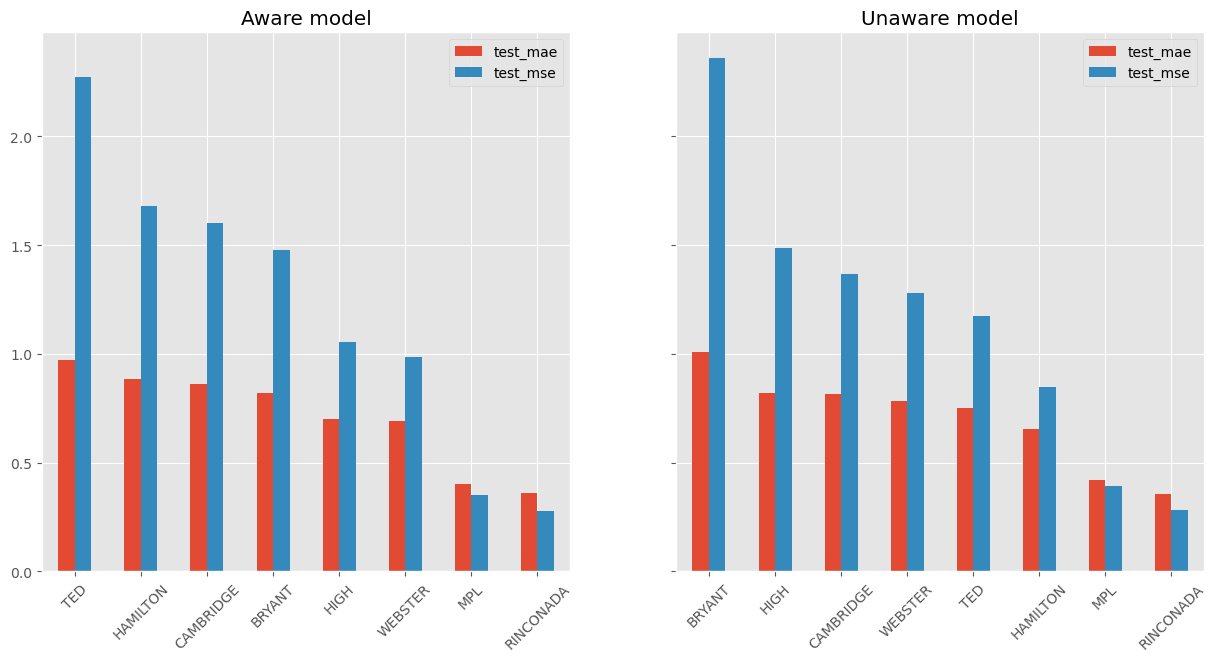

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7), sharey=True)
df_aware.sort_values('test_mae', ascending=False).plot(kind='bar', y=['test_mae', 'test_mse'], figsize=(15, 7), rot=45, title='Aware model', ax=axs[0])
df_unaware.sort_values('test_mae', ascending=False).plot(kind='bar', y=['test_mae', 'test_mse'], figsize=(15, 7), rot=45, title='Unaware model', ax=axs[1])


,test_loss,test_loss_true,test_mae,test_mse,test_rmse,aware,test_loss_perc,test_loss_true_perc,test_mae_perc,test_mse_perc,cluster
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRYANT
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAMBRIDGE
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAMILTON
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIGH
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPL
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RINCONADA
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TED
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEBSTER


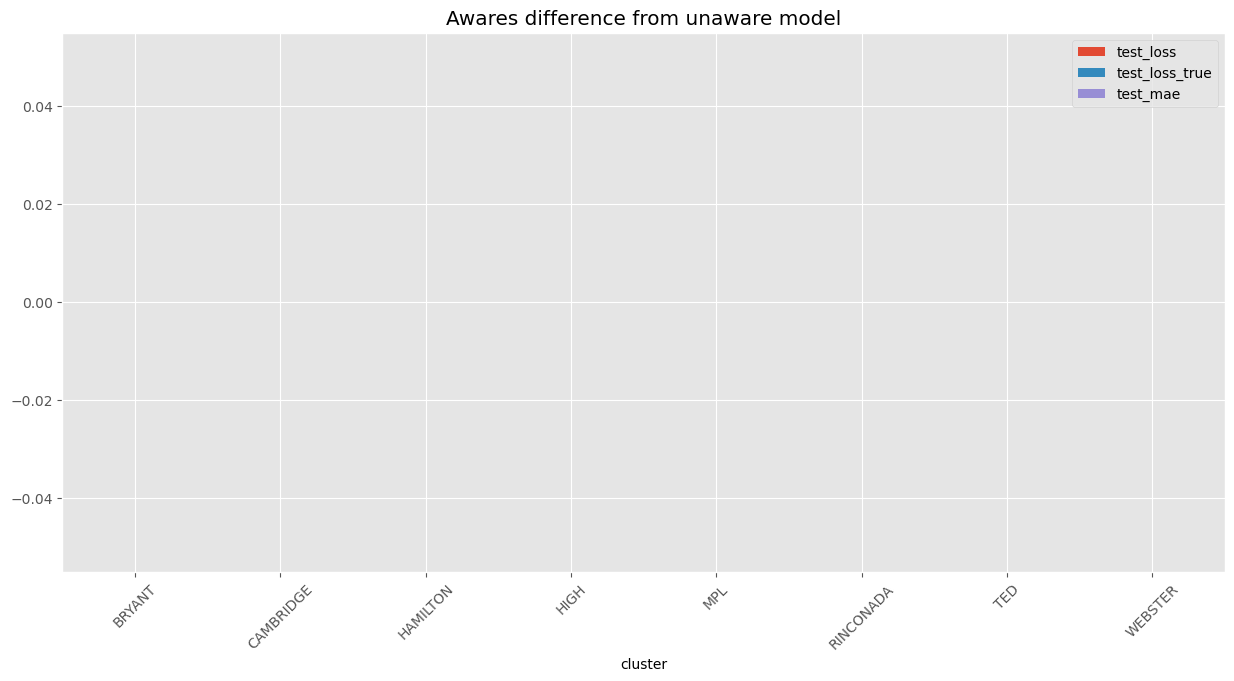

In [10]:
df_unaware['aware'] = 0
df_aware['aware'] = 1

# join
df = pd.concat([df_unaware.reset_index(), df_aware.reset_index()], axis=0)
boi = df.groupby('index').diff().dropna().copy()
boi["cluster"] = df_aware.index
boi.plot(kind='bar', x='cluster', y=['test_loss', 'test_loss_true', 'test_mae'], figsize=(15, 7), rot=45, title='Awares difference from unaware model')
boi

In [11]:
df_unaware.mean(), df_aware.mean()

(test_loss         1.126224
 test_loss_true   -0.067258
 test_mae          0.701388
 test_mse          1.148286
 test_rmse         1.013356
 aware             0.000000
 dtype: float64,
 test_loss              0.917248
 test_loss_true        -0.072698
 test_mae               0.711324
 test_mse               1.211837
 test_rmse              1.039738
 test_loss_perc         0.125000
 test_loss_true_perc    0.125000
 test_mae_perc          0.125000
 test_mse_perc          0.125000
 aware                  1.000000
 dtype: float64)

In [12]:
import pandas as pd

data_aware_48 = {
    'cluster': ['BRYANT', 'BRYANT', 'BRYANT', 'BRYANT', 'BRYANT', 'CAMBRIDGE', 'CAMBRIDGE', 'CAMBRIDGE', 'CAMBRIDGE', 'CAMBRIDGE', 
                'HAMILTON', 'HAMILTON', 'HAMILTON', 'HAMILTON', 'HAMILTON', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
                'MPL', 'MPL', 'MPL', 'MPL', 'MPL', 'RINCONADA', 'RINCONADA', 'RINCONADA', 'RINCONADA', 'RINCONADA',
                'TED', 'TED', 'TED', 'TED', 'TED', 'WEBSTER', 'WEBSTER', 'WEBSTER', 'WEBSTER', 'WEBSTER'],
    'metric': ['test_loss', 'test_loss_true', 'test_mae', 'test_mse', 'test_rmse']*8,
    'value': [1.5141452550888062, -0.4831616282463074, 1.2048758268356323, 3.2367372512817383, 1.7607520818710327,
              1.817612886428833, -0.33414170145988464, 1.3024611473083496, 3.55499267578125, 1.8471366167068481,
              0.6791661381721497, 0.6130484342575073, 0.7992165684700012, 1.1902636289596558, 1.0747240781784058,
              1.3326752185821533, -0.2403743714094162, 1.0264407396316528, 2.2439396381378174, 1.489281177520752,
              0.9122055768966675, 0.83580482006073, 0.6898483037948608, 0.8850300312042236, 0.9341673851013184,
              1.0810937881469727, 1.0158835649490356, 0.7473127841949463, 0.9508905410766602, 0.9646220803260803,
              1.2992722988128662, 0.19175885617733002, 0.912567675113678, 1.6620492935180664, 1.2714000940322876,
              1.0895084142684937, -0.06050635129213333, 0.9209852814674377, 1.6762851476669312, 1.283489465713501]
}

df_aware_48 = pd.DataFrame(data_aware_48)
df_aware_48 = df_aware_48.pivot(index='cluster', columns='metric', values='value')
df_aware_48

metric,test_loss,test_loss_true,test_mae,test_mse,test_rmse
cluster,,,,,
BRYANT,1.514145,-0.483162,1.204876,3.236737,1.760752
CAMBRIDGE,1.817613,-0.334142,1.302461,3.554993,1.847137
HAMILTON,0.679166,0.613048,0.799217,1.190264,1.074724
HIGH,1.332675,-0.240374,1.026441,2.243940,1.489281
MPL,0.912206,0.835805,0.689848,0.885030,0.934167
RINCONADA,1.081094,1.015884,0.747313,0.950891,0.964622
TED,1.299272,0.191759,0.912568,1.662049,1.271400
WEBSTER,1.089508,-0.060506,0.920985,1.676285,1.283489


In [13]:
import pandas as pd

data_unaware_48 = {
    "cluster": ["BRYANT", "BRYANT", "BRYANT", "BRYANT", "BRYANT", 
                "CAMBRIDGE", "CAMBRIDGE", "CAMBRIDGE", "CAMBRIDGE", "CAMBRIDGE", 
                "HAMILTON", "HAMILTON", "HAMILTON", "HAMILTON", "HAMILTON", 
                "HIGH", "HIGH", "HIGH", "HIGH", "HIGH", 
                "MPL", "MPL", "MPL", "MPL", "MPL", 
                "RINCONADA", "RINCONADA", "RINCONADA", "RINCONADA", "RINCONADA", 
                "TED", "TED", "TED", "TED", "TED", 
                "WEBSTER", "WEBSTER", "WEBSTER", "WEBSTER", "WEBSTER"],
    "metric": ["test_loss", "test_loss_true", "test_mae", "test_mse", "test_rmse"] * 8,
    "value": [1.7059719562530518, -0.33040153980255127, 1.3594045639038086, 4.210822582244873, 2.0130903720855713, 
              1.9008188247680664, -0.2757745087146759, 1.3494726419448853, 3.8600807189941406, 1.9299962520599365, 
              1.1387323141098022, 0.5896154046058655, 0.6775365471839905, 0.8283964395523071, 0.9028381109237671, 
              1.5073838233947754, -0.12081479281187057, 1.155085802078247, 2.8828468322753906, 1.6890071630477905, 
              1.0783956050872803, 0.8388298749923706, 0.6741956472396851, 0.8261075615882874, 0.9019244909286499, 
              1.1498725414276123, 0.9903906583786011, 0.6977241635322571, 0.8194048404693604, 0.8946484327316284, 
              1.3945482969284058, 0.24389329552650452, 0.9815183877944946, 1.956606149673462, 1.378797173500061, 
              1.3482366800308228, 0.03960903361439705, 1.0567704439163208, 2.201364755630493, 1.467787742614746]
}

df_unaware_48 = pd.DataFrame(data_unaware_48)
df_unaware_48 = df_unaware_48.pivot(index='cluster', columns='metric', values='value')
df_unaware_48

metric,test_loss,test_loss_true,test_mae,test_mse,test_rmse
cluster,,,,,
BRYANT,1.705972,-0.330402,1.359405,4.210823,2.013090
CAMBRIDGE,1.900819,-0.275775,1.349473,3.860081,1.929996
HAMILTON,1.138732,0.589615,0.677537,0.828396,0.902838
HIGH,1.507384,-0.120815,1.155086,2.882847,1.689007
MPL,1.078396,0.838830,0.674196,0.826108,0.901924
RINCONADA,1.149873,0.990391,0.697724,0.819405,0.894648
TED,1.394548,0.243893,0.981518,1.956606,1.378797
WEBSTER,1.348237,0.039609,1.056770,2.201365,1.467788


<Axes: title={'center': 'Aware model'}, xlabel='cluster'>

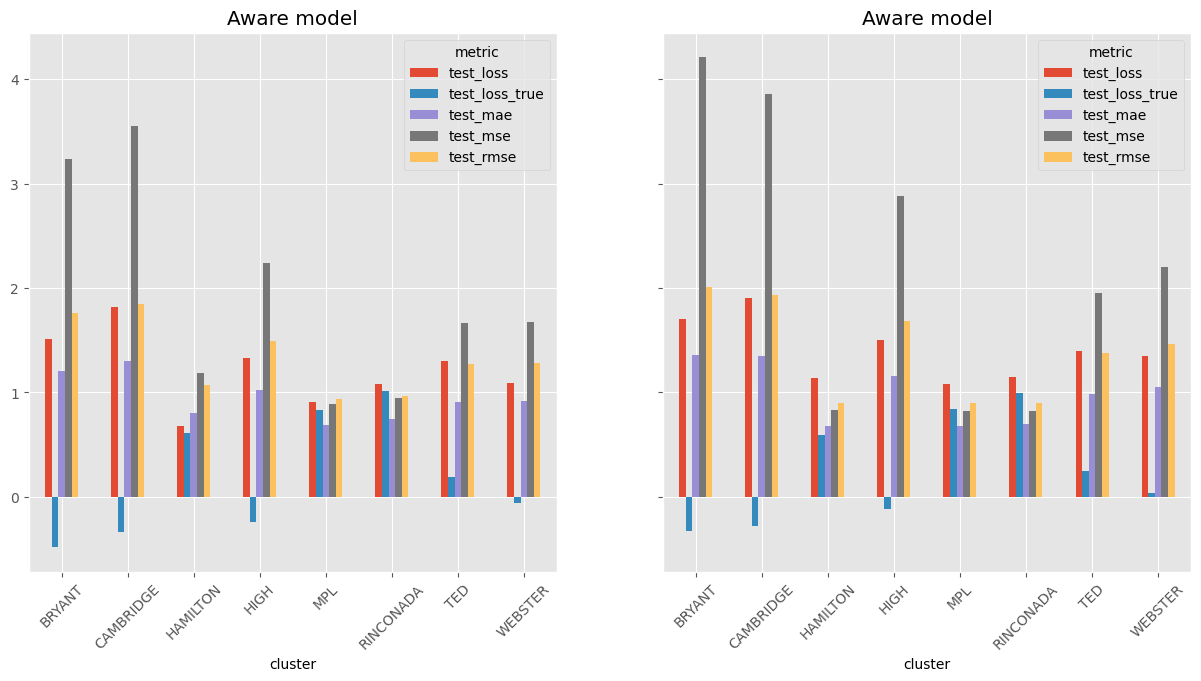

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7), sharey=True)
df_aware_48.plot(kind='bar', y=['test_loss', 'test_loss_true', 'test_mae', 'test_mse', 'test_rmse'], figsize=(15, 7), rot=45, title='Aware model', ax=axs[0])
df_unaware_48.plot(kind='bar', y=['test_loss', 'test_loss_true', 'test_mae', 'test_mse', 'test_rmse'], figsize=(15, 7), rot=45, title='Aware model', ax=axs[1])


metric,test_loss,test_loss_true,test_mae,test_mse,test_rmse,aware,cluster
0,-0.191827,-0.152760,-0.154529,-0.974085,-0.252338,1.0,BRYANT
1,-0.083206,-0.058367,-0.047011,-0.305088,-0.082860,1.0,CAMBRIDGE
2,-0.459566,0.023433,0.121680,0.361867,0.171886,1.0,HAMILTON
3,-0.174709,-0.119560,-0.128645,-0.638907,-0.199726,1.0,HIGH
4,-0.166190,-0.003025,0.015653,0.058922,0.032243,1.0,MPL
5,-0.068779,0.025493,0.049589,0.131486,0.069974,1.0,RINCONADA
6,-0.095276,-0.052134,-0.068951,-0.294557,-0.107397,1.0,TED
7,-0.258728,-0.100115,-0.135785,-0.525080,-0.184298,1.0,WEBSTER


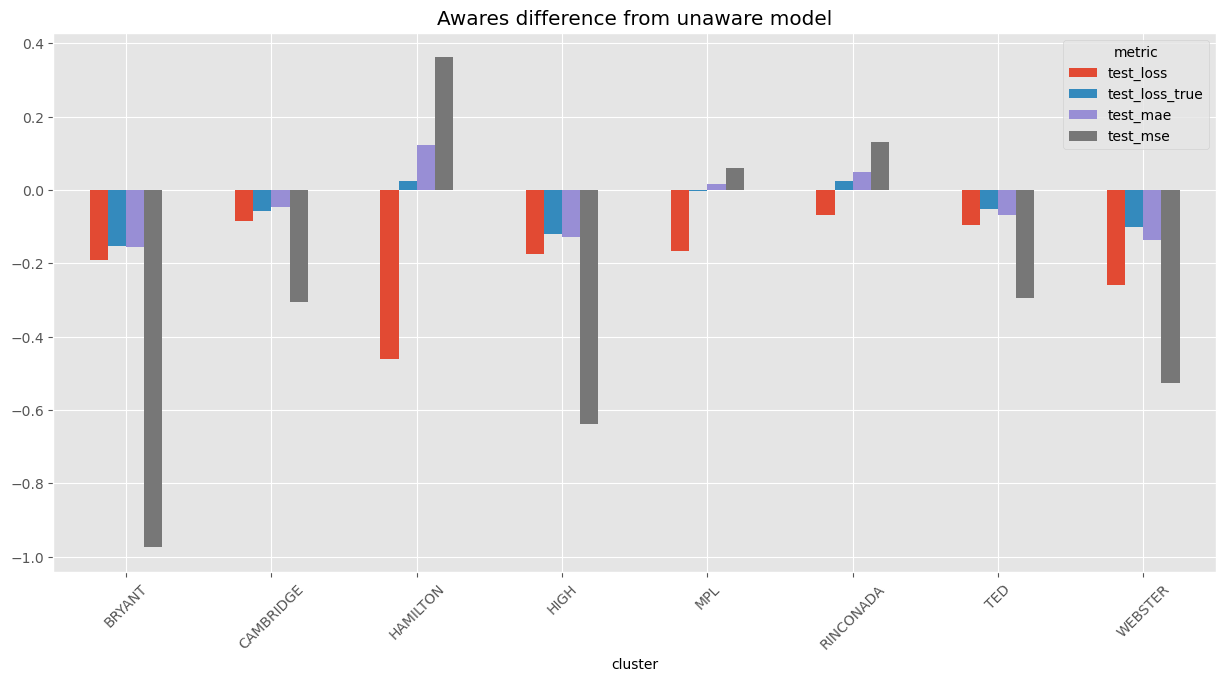

In [15]:
df_unaware_48['aware'] = 0
df_aware_48['aware'] = 1

# join
df_48 = pd.concat([df_unaware_48.reset_index(), df_aware_48.reset_index()], axis=0)
boi_48 = df_48.groupby('cluster').diff().dropna().copy()
boi_48["cluster"] = df_aware_48.index
boi_48.plot(kind='bar', x='cluster', y=['test_loss', 'test_loss_true', 'test_mae', 'test_mse'], figsize=(15, 7), rot=45, title='Awares difference from unaware model')
boi_48

In [16]:
df_aware_48.mean(), df_unaware_48.mean()

(metric
 test_loss         1.215710
 test_loss_true    0.192289
 test_mae          0.950464
 test_mse          1.925024
 test_rmse         1.328197
 aware             1.000000
 dtype: float64,
 metric
 test_loss         1.402995
 test_loss_true    0.246918
 test_mae          0.993964
 test_mse          2.198204
 test_rmse         1.397261
 aware             0.000000
 dtype: float64)

In [17]:
np.array([-0.0727, -0.06914, -0.06905, -0.05615, -0.06168]).mean().round(2)

-0.07

In [18]:
np.array([0.7113, 0.7018, 0.7411, 0.7723, 0.7438]).mean().round(2)

0.73

In [19]:
np.array([1.212, 1.179, 1.315, 1.426, 1.362]).std()

0.09200304342792144